# NYC Temperature vs. Daily Sales Revenue

## Here, I wanted to explore if there was a relationship between the daily temperature and the total sales revenue from that day, specifically sales in Coffee and Tea.

### My hypothesis is that the colder it is outside, the more likely people are going to buy a coffee or tea beverage. So we should see a negative relationship between temperature and transaction totals.

## I pulled the NYC daily weather from Visual Crossing, which you can find here (https://www.visualcrossing.com/weather-history/New+York+City%2CUSA).

### Note: I only pulled from 1/1/23 to 6/30/23, which are the start and end dates of the coffee dataset and only the average weather from the day, overall, rather than hourly weather, due to the API call request limit of 1000.

In [98]:
# import dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import statistics
import scipy.stats as stats

In [99]:
# bring in coffee3_df.csv as coffee_df, and New York City, New York F as nyc_weather_df

coffee_df = pd.read_csv('coffee3_df.csv', index_col=0)
nyc_weather_df = pd.read_csv('New York City, New York F 2023-01-01 to 2023-06-30.csv')


In [100]:
# Check the DataFrames
coffee_df.head()


,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,transaction_total,day_of_week
transaction_id,,,,,,,,,,,,
1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6.0,Sunday
2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,Sunday
3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,9.0,Sunday
4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2.0,Sunday
5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,Sunday


In [101]:
nyc_weather_df.head()

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,"New York City, New York",2023-01-01,54.0,50.0,52.0,54.0,47.3,51.9,39.7,64.9,...,8.4,4,10,2023-01-01T07:20:12,2023-01-01T16:39:10,0.32,"Rain, Partially cloudy",Becoming cloudy in the afternoon with early mo...,rain,"72505394728,KLGA,F8726,KNYC,F1417,72503014732"
1,"New York City, New York",2023-01-02,56.0,47.0,52.3,56.0,44.7,51.7,39.6,62.3,...,3.6,3,10,2023-01-02T07:20:17,2023-01-02T16:40:01,0.35,"Rain, Partially cloudy",Becoming cloudy in the afternoon with late aft...,rain,"72505394728,KLGA,F8726,KNYC,F1417,72503014732"
2,"New York City, New York",2023-01-03,55.5,46.2,51.1,55.5,43.9,50.5,47.6,87.9,...,1.5,1,10,2023-01-03T07:20:21,2023-01-03T16:40:53,0.39,"Rain, Overcast",Cloudy skies throughout the day with rain in t...,rain,"72505394728,KLGA,KNYC,F1417,72503014732"
3,"New York City, New York",2023-01-04,65.7,48.6,57.9,65.7,45.2,57.6,51.5,79.7,...,5.1,3,10,2023-01-04T07:20:22,2023-01-04T16:41:48,0.42,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"72505394728,KLGA,F8726,KNYC,F1417,72503014732"
4,"New York City, New York",2023-01-05,49.0,44.7,47.3,47.8,39.7,44.6,44.7,90.7,...,2.3,1,10,2023-01-05T07:20:21,2023-01-05T16:42:43,0.46,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72505394728,KLGA,F8726,KNYC,F1417,72503014732"


In [102]:
# Clean up nyc_weather_df to only include what's needed... What is needed, though?

nyc_weather_df.info() # keep the datetime(act as where to join), tempmax, tempmin, temp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181 entries, 0 to 180
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              181 non-null    object 
 1   datetime          181 non-null    object 
 2   tempmax           181 non-null    float64
 3   tempmin           181 non-null    float64
 4   temp              181 non-null    float64
 5   feelslikemax      181 non-null    float64
 6   feelslikemin      181 non-null    float64
 7   feelslike         181 non-null    float64
 8   dew               181 non-null    float64
 9   humidity          181 non-null    float64
 10  precip            181 non-null    float64
 11  precipprob        181 non-null    int64  
 12  precipcover       181 non-null    float64
 13  preciptype        89 non-null     object 
 14  snow              181 non-null    float64
 15  snowdepth         181 non-null    float64
 16  windgust          181 non-null    float64
 1

In [103]:
# create a nyc_temp_df from nyc_weather_df

nyc_temp_df = nyc_weather_df[['datetime','tempmax','tempmin','temp']]
nyc_temp_df

,datetime,tempmax,tempmin,temp
0,2023-01-01,54.0,50.0,52.0
1,2023-01-02,56.0,47.0,52.3
2,2023-01-03,55.5,46.2,51.1
3,2023-01-04,65.7,48.6,57.9
4,2023-01-05,49.0,44.7,47.3
...,...,...,...,...
176,2023-06-26,79.0,69.8,72.8
177,2023-06-27,80.7,66.9,71.9
178,2023-06-28,82.1,68.0,74.1
179,2023-06-29,82.9,66.7,74.4


In [104]:
# Left join coffee_df w/ nyc_temp_df on dates

coffee_and_temp_df = pd.merge(coffee_df, nyc_temp_df, how = 'left', left_on= 'transaction_date', right_on= 'datetime')
coffee_and_temp_df = coffee_and_temp_df.drop('datetime', axis = 1)
coffee_and_temp_df.head()

,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,transaction_total,day_of_week,tempmax,tempmin,temp
0,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6.0,Sunday,54.0,50.0,52.0
1,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,Sunday,54.0,50.0,52.0
2,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,9.0,Sunday,54.0,50.0,52.0
3,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2.0,Sunday,54.0,50.0,52.0
4,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,Sunday,54.0,50.0,52.0


In [105]:
# Understand the new DataFrame

print(coffee_and_temp_df.info()) # no null values and dtypes are appropriate
print(coffee_and_temp_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   transaction_date   149116 non-null  object 
 1   transaction_time   149116 non-null  object 
 2   transaction_qty    149116 non-null  int64  
 3   store_id           149116 non-null  int64  
 4   store_location     149116 non-null  object 
 5   product_id         149116 non-null  int64  
 6   unit_price         149116 non-null  float64
 7   product_category   149116 non-null  object 
 8   product_type       149116 non-null  object 
 9   product_detail     149116 non-null  object 
 10  transaction_total  149116 non-null  float64
 11  day_of_week        149116 non-null  object 
 12  tempmax            149116 non-null  float64
 13  tempmin            149116 non-null  float64
 14  temp               149116 non-null  float64
dtypes: float64(5), int64(3), object(7)
memory usage: 17

In [106]:
# Create a new DataFrame w/ new data where it's only single day observations w/ transaction totals and daily temp.

just_coff_and_tea_df = coffee_and_temp_df[coffee_and_temp_df['product_category'].isin(['Coffee','Tea'])]

series = just_coff_and_tea_df.groupby('transaction_date')['transaction_total'].sum()
x = series.index
y = series.values
y2 = just_coff_and_tea_df[['transaction_date','temp']].drop_duplicates()
y2 = y2['temp']
y2 = y2.values
plot_data = pd.DataFrame(x)
plot_data['transaction_total'] = y
plot_data['temp'] = y2
plot_data['transaction_date'] = pd.to_datetime(plot_data['transaction_date'])
plot_data.dtypes # ensure 'transaction_date' columnn is datetime64

transaction_date     datetime64[ns]
transaction_total           float64
temp                        float64
dtype: object

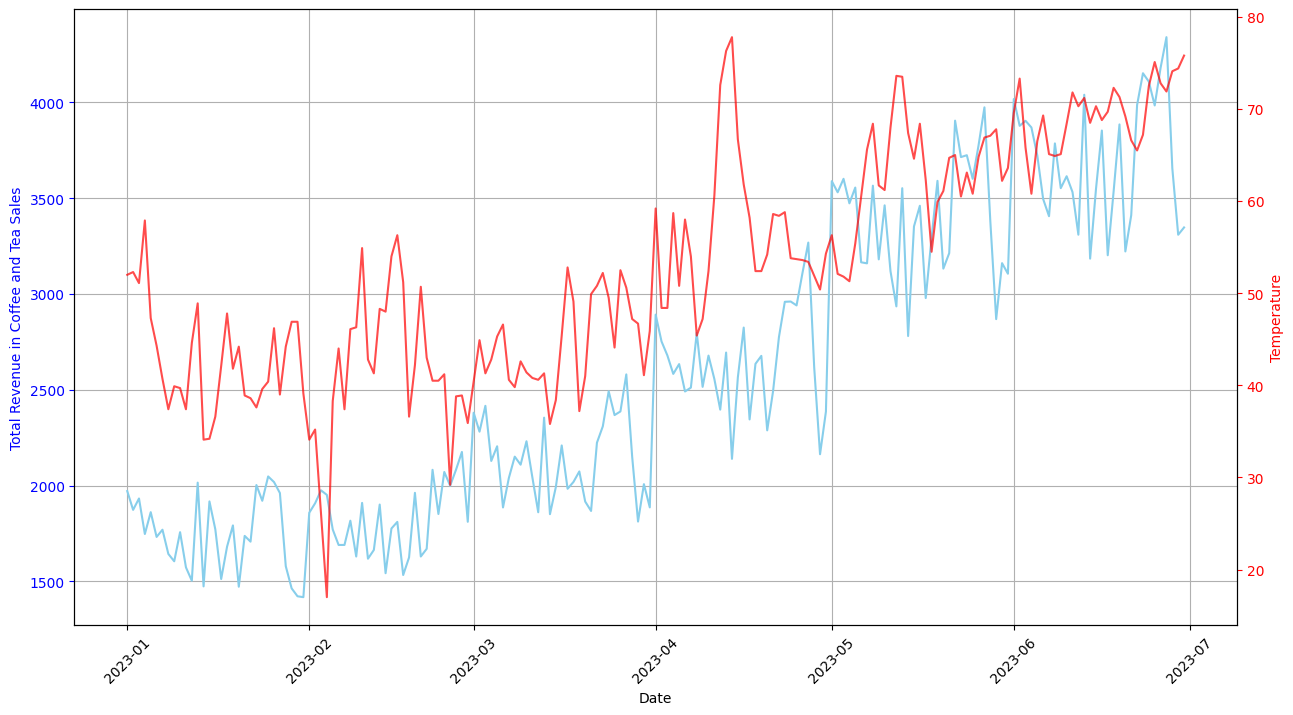

In [107]:
# Plot out in line chart

x = plot_data['transaction_date']
y = plot_data['transaction_total']
y2 = plot_data['temp']

fig, ax1 = plt.subplots(figsize=(15,8))

ax1.plot(x,y, color = 'skyblue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Revenue in Coffee and Tea Sales', color = 'blue')
ax1.tick_params('y',colors = 'blue')

ax2 = ax1.twinx()
ax2.plot(x,y2, color = 'red', alpha = .7)
ax2.set_ylabel('Temperature', color = 'red')
ax2.tick_params('y',colors = 'red')
ax1.grid()

ax1.xaxis.set_tick_params(rotation=45)

### Above, we can vaguely see a possibility of a relationship between daily temperature and transaction totals for the day. People will buy more coffee and tea the hotter it is outside. Maven Roasters could be selling coffee and teas that are iced/cold. 

### This is the opposite of my hypothesis, now I want to see if these two variables have a relationship, and what kind.

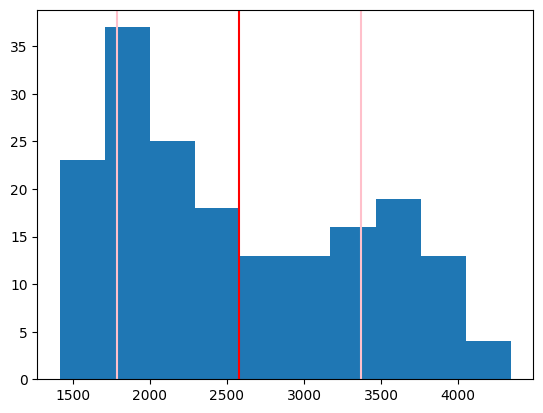

Mean: 2576.57
Standard Deviations: 3367.24, 1785.89


In [108]:
# Are the transaction totals representative of normal distribution? Create a plot to visualize the curve, it should be a bell curve.

trans_totals = plot_data['transaction_total']

mean = np.mean(trans_totals)
sd = np.std(trans_totals)
sd1 = mean + sd
sd2 = mean - sd

plt.hist(trans_totals)
plt.axvline(x = mean, color = 'red') # this line will show us where the mean is, it means normal distribution if line at peak of bell curve
plt.axvline(x = sd1, color = 'pink') # these two pink lines will show us where the standard deviations are
plt.axvline(x = sd2, color = 'pink')
plt.show()
print(f"Mean: {mean:.2f}\nStandard Deviations: {sd1:.2f}, {sd2:.2f}")

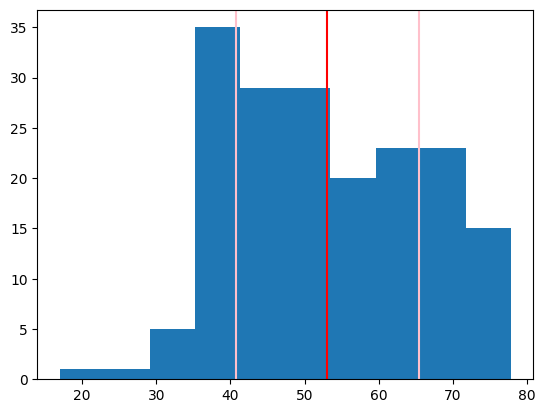

Mean: 53.06
Standard Deviations: 65.42, 40.70


In [109]:
# Are the temperatures representative of normal distribution? Create a plot to visualize the curve, it should be a bell curve.

trans_totals = plot_data['temp']

mean = np.mean(trans_totals)
sd = np.std(trans_totals)
sd1 = mean + sd
sd2 = mean - sd

plt.hist(trans_totals)
plt.axvline(x = mean, color = 'red') # this line will show us where the mean is, it means normal distribution if line at peak of bell curve
plt.axvline(x = sd1, color = 'pink') # these two pink lines will show us where the standard deviations are
plt.axvline(x = sd2, color = 'pink')
plt.show()
print(f"Mean: {mean:.2f}\nStandard Deviations: {sd1:.2f}, {sd2:.2f}")

### From the above graphs, we can see that both the temperatures and total revenues do not have normal distribution, so the Pearson Correlation (r) wouldn't mean much. However, we can use Kendall's Tau, as it doesn't require normal distribution of the data.

### However, it does require rankings, which I will create using the rankdata method.

In [110]:
# Create rankings for Kendall's Tau test
ranks_y = stats.rankdata(y)
ranks_y2 = stats.rankdata(y2)

# input ranks list into Kendall's Tau method

tau, p_value = stats.kendalltau(ranks_y,ranks_y2)
print(f"tau: {tau}")
print(f"p-value: {p_value}")

tau: 0.5673643448005218
p-value: 9.453923948731092e-30


### After finding the tau and p-value, we can determine that there is a moderate positive correlation between temperature and total revenue in coffee and tea sales.

#### Tau is **.567**, which is basically right in between 0 and 1, indicating a moderate positive correlation.
#### the p-value is **.945e-30** is below .05 (the cutoff value for what is considered statistically significant), which means that there is strong evidence to reject the null hypothesis.

Text(0.5, 1.0, 'Scatter Plot of Temperature vs. Total Coffee and Tea Revenue')

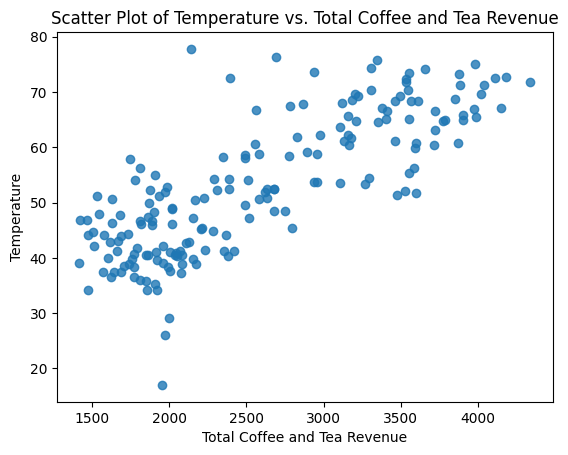

In [111]:
# Create a scatter plot of transaction_totals and temp

fig, ax3 = plt.subplots()
ax3.scatter(y, y2, alpha = .8)
ax3.set_xlabel("Total Coffee and Tea Revenue")
ax3.set_ylabel("Temperature")
plt.title("Scatter Plot of Temperature vs. Total Coffee and Tea Revenue")

## Final Thoughts

### There is a statistically significant moderate positive correlation between temperature and total revenue in coffee and tea sales. 

### Notes: 
#### Would love to see if we can be provided an entire year's worth of data and see how that influences the coefficient.
#### If it weren't for the API call limit of 1000, I would love to delve deeper on an hourly basis.
#### I've made mistakes in an earlier version of this notebook where I used Pearson's coefficient after improperly using a scatter plot and the norm.pdf method to determine the distribution. It resulted in a "perfect" bell curve for both variables. I learned to use histograms and binning to properly plot out distributions.
#### 